<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


<h1>Linear regression 1D: Training Two Parameter</h1>


<h2>Objective</h2><ul><li> How to train the model and visualize the loss results.</li></ul> 


<h2>Table of Contents</h2>
<p>In this lab, you will train a model with PyTorch by using the data that we created. The model will have the slope and bias. And we will review how to make a prediction in several different ways by using PyTorch.</p>

<ul>
    <li><a href="#Make-Some-Data">Make Some Data</a></li>
    <li><a href="#Create-the-Model-and-Cost-Function-(Total-Loss)">Create the Model and Cost Function (Total Loss) </a></li>
    <li><a href="#Train-the-Model">Train the Model </a></li>
</ul>
<p>Estimated Time Needed: <strong>20 min</strong></ul>

<hr>


<h2>Preparation</h2>


We'll need the following libraries:  


In [1]:
%%time
%pip install numpy matplotlib
%pip install torch==1.13.1+cpu torchvision==0.14.1+cpu torchaudio==0.13.1+cpu \
--index-url https://download.pytorch.org/whl/cpu

Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cpu
Note: you may need to restart the kernel to use updated packages.
CPU times: user 111 ms, sys: 26.9 ms, total: 138 ms
Wall time: 5.33 s


In [2]:
# These are the libraries we are going to use in the lab.

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

The class <code>plot_error_surfaces</code> is just to help you visualize the data space and the parameter space during training and has nothing to do with PyTorch. 


In [3]:
# The class for plot the diagram

class plot_error_surfaces(object):
    
    # Constructor
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True):
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)    
        Z = np.zeros((30,30))
        count1 = 0
        self.y = Y.numpy()
        self.x = X.numpy()
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                Z[count1, count2] = np.mean((self.y - w2 * self.x + b2) ** 2)
                count2 += 1
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.W = []
        self.B = []
        self.LOSS = []
        self.n = 0
        if go == True:
            plt.figure()
            plt.figure(figsize = (7.5, 5))
            plt.axes(projection='3d').plot_surface(self.w, self.b, self.Z, rstride = 1, cstride = 1,cmap = 'viridis', edgecolor = 'none')
            plt.title('Cost/Total Loss Surface')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.show()
            plt.figure()
            plt.title('Cost/Total Loss Surface Contour')
            plt.xlabel('w')
            plt.ylabel('b')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
    
    # Setter
    def set_para_loss(self, W, B, loss):
        self.n = self.n + 1
        self.W.append(W)
        self.B.append(B)
        self.LOSS.append(loss)
    
    # Plot diagram
    def final_plot(self): 
        ax = plt.axes(projection = '3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        ax.scatter(self.W,self.B, self.LOSS, c = 'r', marker = 'x', s = 200, alpha = 1)
        plt.figure()
        plt.contour(self.w,self.b, self.Z)
        plt.scatter(self.W, self.B, c = 'r', marker = 'x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
    
    # Plot diagram
    def plot_ps(self):
        plt.subplot(121)
        plt.ylim
        plt.plot(self.x, self.y, 'ro', label="training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label = "estimated line")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-10, 15))
        plt.title('Data Space Iteration: ' + str(self.n))

        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c = 'r', marker = 'x')
        plt.title('Total Loss Surface Contour Iteration' + str(self.n))
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()

<!--Empty Space for separating topics-->


<h2 id="Makeup_Data">Make Some Data</h2>


Import PyTorch: 


In [4]:
# Import PyTorch library

import torch

Start with generating values from -3 to 3 that create a line with a slope of 1 and a bias of -1. This is the line that you need to estimate.


In [5]:
# Create f(X) with a slope of 1 and a bias of -1

X = torch.arange(-3, 3, 0.1).view(-1, 1)
f = 1 * X - 1

Now, add some noise to the data:


In [6]:
# Add noise

Y = f + 0.1 * torch.randn(X.size())

Plot the line and <code>Y</code> with noise:


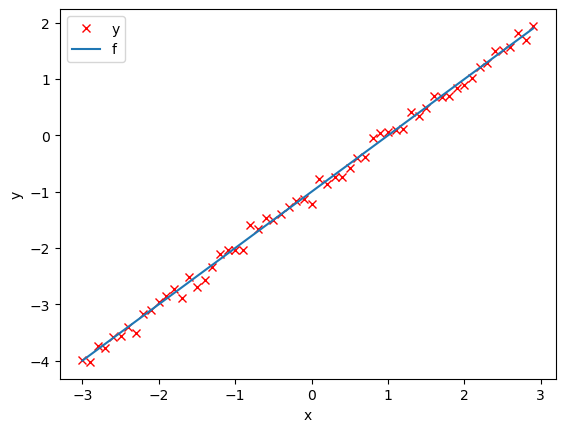

In [7]:
# Plot out the line and the points with noise

plt.plot(X.numpy(), Y.numpy(), 'rx', label = 'y')
plt.plot(X.numpy(), f.numpy(), label = 'f')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

<h2 id="Model_Cost">Create the Model and Cost Function (Total Loss)</h2>


Define the <code>forward</code> function: 


In [8]:
# Define the forward function

def forward(x):
    return w * x + b

Define the cost or criterion function (MSE): 


In [9]:
# Define the MSE Loss function

def criterion(yhat,y):
    return torch.mean((yhat-y)**2)

Create a <code> plot_error_surfaces</code> object to visualize the data space and the parameter space during training:


<Figure size 640x480 with 0 Axes>

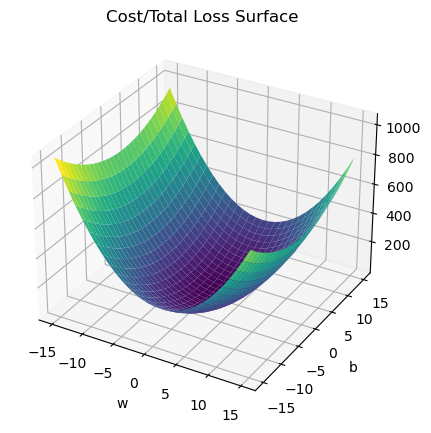

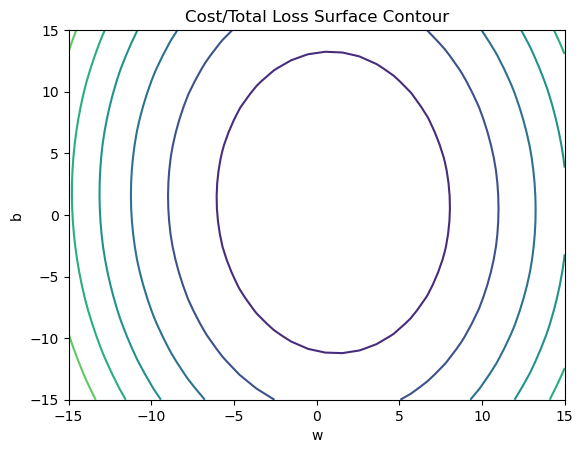

In [10]:
# Create plot_error_surfaces for viewing the data

get_surface = plot_error_surfaces(15, 15, X, Y, 30)

<!--Empty Space for separating topics-->


<h2 id="Train">Train the Model</h2>


Create model parameters <code>w</code>, <code>b</code> by setting the argument <code>requires_grad</code> to True because we must learn it using the data.


In [11]:
# Define the parameters w, b for y = wx + b

w = torch.tensor(-15.0, requires_grad = True)
b = torch.tensor(-10.0, requires_grad = True)

Set the learning rate to 0.1 and create an empty list <code>LOSS</code> for storing the loss for each iteration.


In [12]:
# Define learning rate and create an empty list for containing the loss for each iteration.

lr = 0.1
LOSS = []

Define <code>train_model</code> function for train the model.


In [13]:
# The function for training the model

def train_model(iter):
    
    # Loop
    for epoch in range(iter):
        
        # make a prediction
        Yhat = forward(X)
        
        # calculate the loss 
        loss = criterion(Yhat, Y)

        # Section for plotting
        get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())
        if epoch % 3 == 0:
            get_surface.plot_ps()
            
        # store the loss in the list LOSS
        LOSS.append(loss)
        
        # backward pass: compute gradient of the loss with respect to all the learnable parameters
        loss.backward()
        
        # update parameters slope and bias
        w.data = w.data - lr * w.grad.data
        b.data = b.data - lr * b.grad.data
        
        # zero the gradients before running the backward pass
        w.grad.data.zero_()
        b.grad.data.zero_()

Run 15 iterations of gradient descent: <b>bug</b> data space is 1 iteration ahead of parameter space 


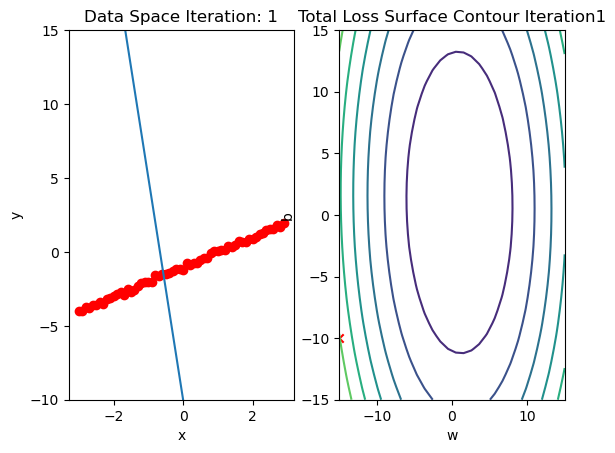

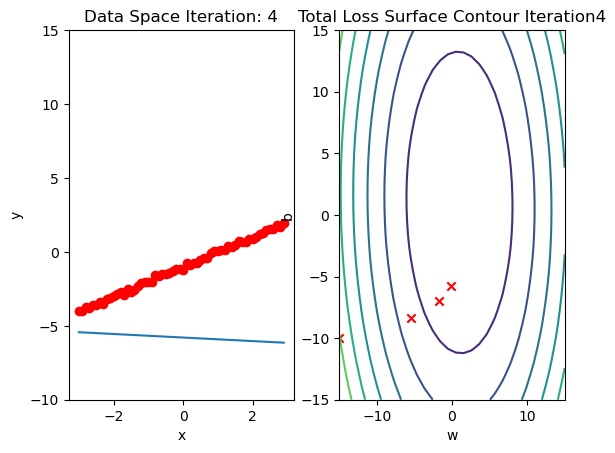

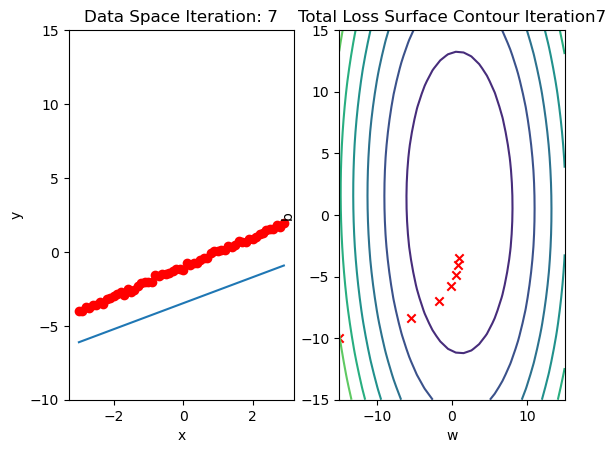

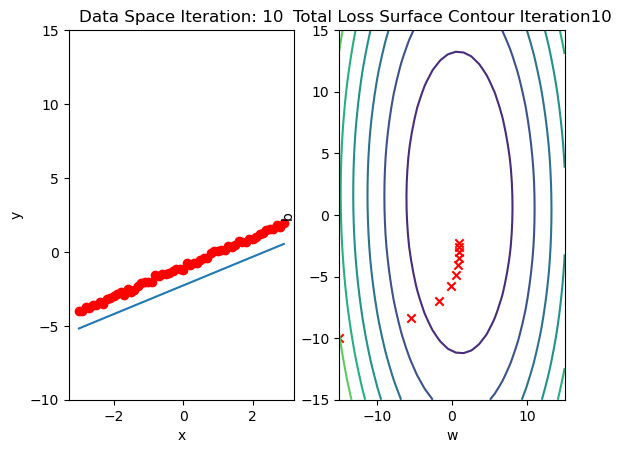

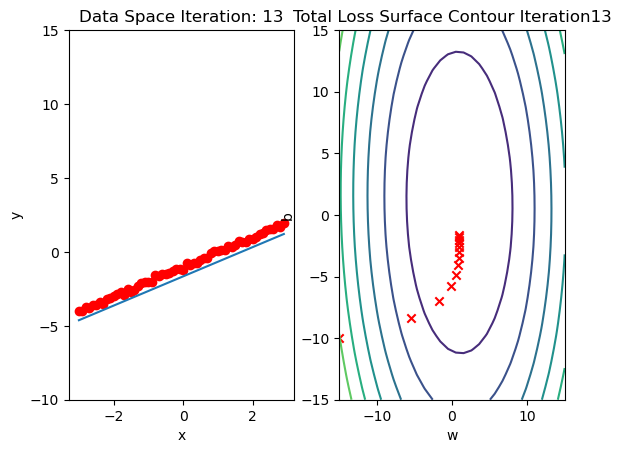

In [14]:
# Train the model with 15 iterations

train_model(15)

Plot total loss/cost surface with loss values for different parameters in red:


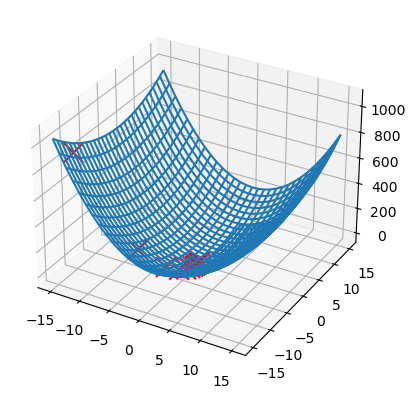

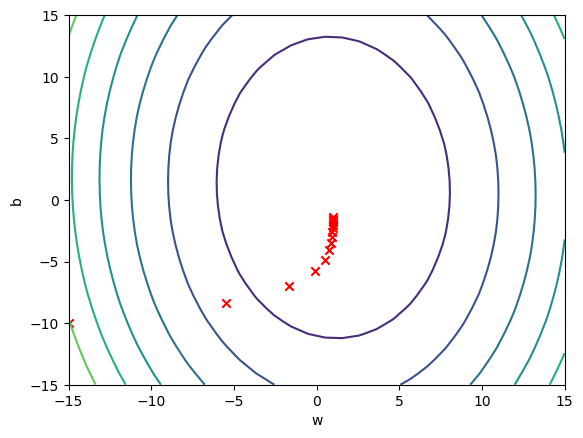

Text(38.097222222222214, 0.5, 'Cost')

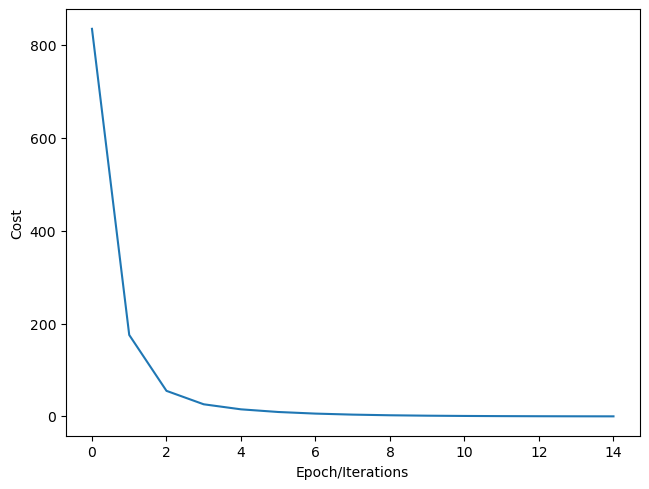

In [15]:
# Plot out the Loss Result

get_surface.final_plot()
LOSS= [ loss.detach().numpy() for loss in LOSS]
plt.plot(LOSS)
plt.tight_layout()
plt.xlabel("Epoch/Iterations")
plt.ylabel("Cost")

<!--Empty Space for separating topics-->


<h3>Practice</h3>


Experiment using s learning rates 0.2 and width the following parameters. Run 15 iterations.


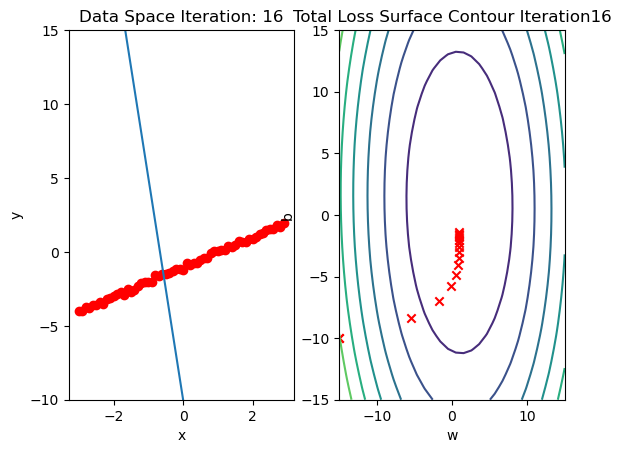

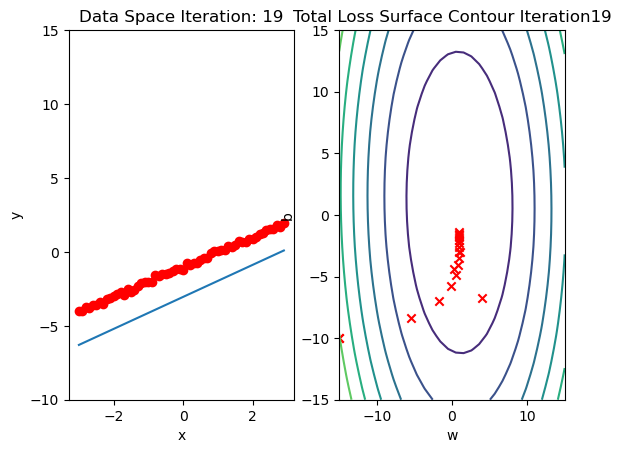

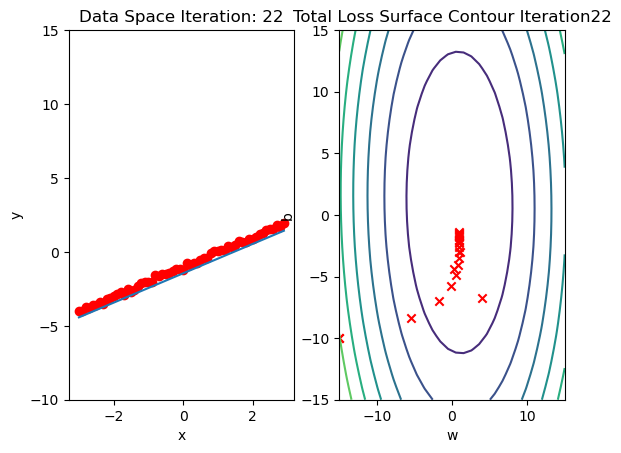

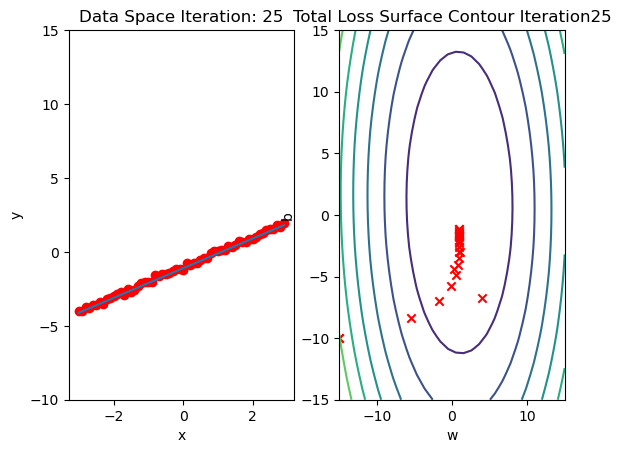

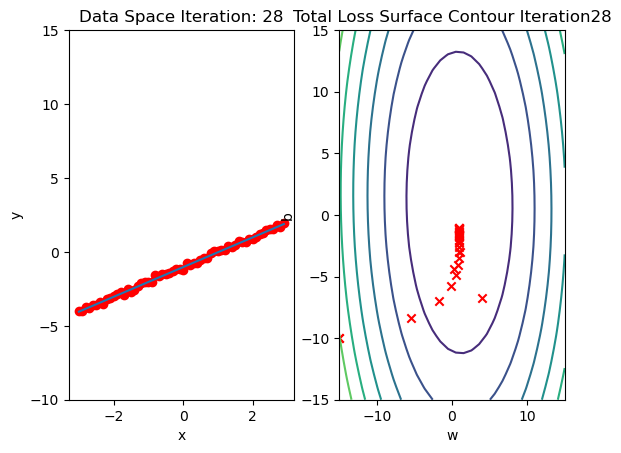

In [16]:
# Practice: train and plot the result with lr = 0.2 and the following parameters

w = torch.tensor(-15.0, requires_grad = True)
b = torch.tensor(-10.0, requires_grad = True)
lr = 0.2
LOSS2 = []

def my_train_model(iter):
    for epoch in range(iter):
        Yhat = forward(X)
        loss = criterion(Yhat, Y)
        get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())
        if epoch % 3 == 0:
            get_surface.plot_ps()
        LOSS2.append(loss)
        loss.backward()
        w.data = w.data - lr * w.grad.data
        b.data = b.data - lr * b.grad.data
        w.grad.data.zero_()
        b.grad.data.zero_()
my_train_model(15)


Double-click <b>here</b> for the solution.
<!-- 
def my_train_model(iter):
    for epoch in range(iter):
        Yhat = forward(X)
        loss = criterion(Yhat, Y)
        get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())
        if epoch % 3 == 0:
            get_surface.plot_ps()
        LOSS2.append(loss)
        loss.backward()
        w.data = w.data - lr * w.grad.data
        b.data = b.data - lr * b.grad.data
        w.grad.data.zero_()
        b.grad.data.zero_()
my_train_model(15)
-->


Plot the <code>LOSS</code> and <code>LOSS2</code>


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

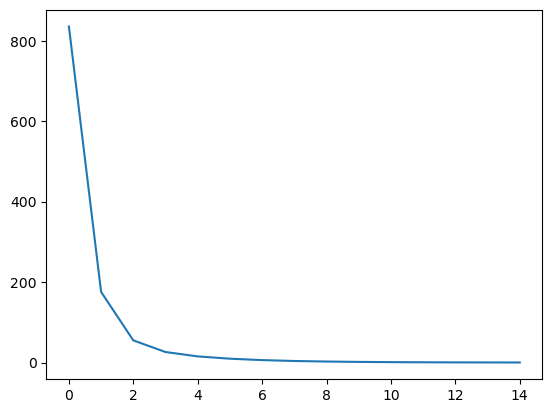

In [24]:
# Practice: Plot the LOSS and LOSS2 in order to compare the Total Loss

# Type your code here
plt.plot(LOSS, label = "LOSS")
plt.plot(LOSS2, label = "LOSS2")
plt.tight_layout()
plt.xlabel("Epoch/Iterations")
plt.ylabel("Cost")
plt.legend()


Double-click <b>here</b> for the solution.
<!--
plt.plot(LOSS, label = "LOSS")
plt.plot(LOSS2, label = "LOSS2")
plt.tight_layout()
plt.xlabel("Epoch/Iterations")
plt.ylabel("Cost")
plt.legend()
-->



<a href="https://dataplatform.cloud.ibm.com/registration/stepone?utm_source=skills_network&utm_content=in_lab_content_link&utm_id=Lab-IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork&context=cpdaas&apps=data_science_experience%2Cwatson_machine_learning"><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0110EN-SkillsNetwork/Template/module%201/images/Watson_Studio.png"></a>


<!--Empty Space for separating topics-->


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="https://www.linkedin.com/in/jiahui-mavis-zhou-a4537814a/">Mavis Zhou</a> 


<!--
## Change Log

|  Date (YYYY-MM-DD) |  Version | Changed By  |  Change Description |
|---|---|---|---|
| 2020-09-21  | 2.0  | Shubham  |  Migrated Lab to Markdown and added to course repo in GitLab |
-->


<hr>





## <h3 align="center"> &#169; IBM Corporation. All rights reserved. <h3/>
